In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from scipy import interpolate

from time import time
from sklearn.decomposition import PCA
import math

import scipy.io

from tqdm import tqdm

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Loading and Fomatting the Required Data

In [2]:
# Load the database of letters and numbers 
subject_folders_path = os.path.join(os.getcwd(), "DB_wacomPaper_v2")
subject_folders = os.listdir(subject_folders_path)

letters_db = dict()
trajectories = dict()
for subject in tqdm(subject_folders):
    letters_db[subject] = dict()
    trajectories[subject] = dict()
    letters_path = os.path.join(subject_folders_path, subject)
    letters_csv = [x for x in os.listdir(letters_path) if ".csv" in x]
    for letter in letters_csv:
        letter_path = os.path.join(letters_path, letter)
        letter_name = letter.split(".csv")[0]
        try:
            letters_db[subject][letter_name] = pd.read_csv(letter_path)
            
            x = letters_db[subject][letter_name]["x"]
            y = -letters_db[subject][letter_name]["y"]
            time = letters_db[subject][letter_name]["time"]
            trajectories[subject][letter_name] = {"x":list(x), "y":list(-y), "t": list(time)}
        except:
            print("Failure : Letter {} from subject {}".format(letter_name, subject))

100%|██████████| 21/21 [00:02<00:00,  7.93it/s]


In [3]:
letters = list(trajectories[subject_folders[0]].keys())
unique_letters = list(set([l[0] for l in letters]))
print(unique_letters)

letters_db = dict()
for letter in unique_letters:
    letters_db[letter[0]] = list()

for subject in trajectories.keys():
    for letter in trajectories[subject]:
        letters_db[letter[0]].append(trajectories[subject][letter])

['a', '3', 'l', 'w', 'x', 'k', 'h', 'j', 't', 'i', 'b', 'u', 'm', 'p', 'n', 's', 'd', '7', 'z', 'c', '4', '5', 'v', '8', 'q', 'f', 'y', '1', 'r', '9', 'o', '6', '0', 'e', '2', 'g']


### Helper Functions For The PreProcessing
Taken from the original letter merging python script

In [4]:
def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

def remove_redundant_points(x_pts, y_pts):
    dists = [distance(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(x_pts[:-1], y_pts[:-1], x_pts[1:], y_pts[1:])]
    same_idx = [i for i in range(len(dists)) if dists[i] == 0]
    x = [x_pts[i] for i in range(len(x_pts)) if i not in same_idx]
    y = [y_pts[i] for i in range(len(y_pts)) if i not in  same_idx]
    return x, y

def evenly_spaced_interpolation(x1,y1,t1,x2,y2,t2, step = 0.01):
    dx, dy = x2-x1, y2-y1
    theta = math.atan2(dy, dx)
    dist = np.sqrt(dx**2+dy**2)

    if dist<step:
        x = [x1,x2]
        y = [y1,y2]
        t = [t1, t2]
    else:
        n_pts = int(np.round(dist/step))+1
        new_step = dist/(n_pts-1)
        x_pts = [x1+i*new_step*math.cos(theta) for i in range(n_pts)]
        y_pts = [y1+i*new_step*math.sin(theta) for i in range(n_pts)]
        x, y = remove_redundant_points(x_pts, y_pts)
        t = [i*(t2-t1)/len(x_pts)+t1 for i in range(len(x_pts))]

    return {"x":x, "y":y, "t":t}

def uniformize_with_specific_step(x_pts, y_pts, t_pts, desired_step = 0.01):
    densified_stroke = [evenly_spaced_interpolation(x1,y1,t1,x2,y2,t2) for x1, y1,t1, x2, y2, t2
                                in zip(x_pts[:-1], y_pts[:-1], t_pts[:-1], x_pts[1:], y_pts[1:], t_pts[1:])]
    x, y = [s["x"] for s in densified_stroke], [s["y"] for s in densified_stroke]
    t = [s["t"] for s in densified_stroke]
    x, y, t = sum(x, []), sum(y, []), sum(t, [])
    return x,y,t

def normalize_wrt_max(x_pts, y_pts):
    dx = max(x_pts)-min(x_pts)
    dy = max(y_pts)-min(y_pts)
    x_pts = [x/max([dx,dy]) for x in x_pts]
    y_pts = [y/max([dx,dy]) for y in y_pts]
    x_pts = [x-min(x_pts)+0.0001 for x in x_pts]
    y_pts = [y-min(y_pts)+0.0001 for y in y_pts]
    return x_pts, y_pts

def interp(vector, numDesiredPoints):
    if len(vector)>2:
        t_current = np.linspace(0, 1, len(vector))
        t_desired = np.linspace(0, 1, numDesiredPoints)
        f = interpolate.interp1d(t_current, vector, kind='linear')
        vector = f(t_desired).tolist()
    return vector

def downsampleShape(x, y, t, numDesiredPoints):
    """ change the length of a stroke with interpolation"""
    if len(x)>2:
        x = interp(x, numDesiredPoints)
        y = interp(y, numDesiredPoints)
        t = interp(t, numDesiredPoints)

    return x,y,t

### Compute the RV Coefficient on the Log Change Matrix 

In [5]:
log_change = dict()
similarity_metric = dict()


for letter in tqdm(letters_db.keys()):
    log_change[letter] = list()
    
    # Compute the log change matrix
    for traj in letters_db[letter]:
        try:
            x, y, t = traj["x"],traj["y"],[t-min(traj["t"])+1 for t in traj["t"]]

            x, y    = normalize_wrt_max(x, y) # Normalize wrt max
            x, y, t = uniformize_with_specific_step(x, y, t, 0.001) # Upsample
            x, y, t = downsampleShape(x, y, t, 100) # Downsample 

            vx = np.array([math.log(xi)-math.log(xj) for xi, xj in zip(x[1:], x[:-1])])
            vy = np.array([math.log(yi)-math.log(yj) for yi, yj in zip(y[1:], y[:-1])])
            vt = np.array([math.log(ti)-math.log(tj) for ti, tj in zip(t[1:], t[:-1])])

            mat = np.vstack((vx, vy))
            mat = np.vstack((mat, vt))
            cov = np.cov(mat)

            log_change[letter].append({"vx":vx, "vy":vy, "vt":vt, "mat":mat, "cov": cov})
        except:
            print("Error")
    
    n_demos = len(log_change[letter])
    
    # Compute the dissimilarity metric using the RV Coefficient
    similarity_metric[letter] = list()
    
    for i in range(n_demos):
        X = log_change[letter][i]["mat"]
        cov_ii = log_change[letter][i]["cov"]
        trace_covii2 = np.trace(np.matmul(cov_ii,cov_ii.transpose()))
        for j in range(i+1, n_demos):
            Y = log_change[letter][j]["mat"]
            cov_jj = log_change[letter][j]["cov"]
            trace_covjj2 = np.trace(np.matmul(cov_jj,cov_jj.transpose()))
            covij = np.matmul(X, Y.transpose())
            covji = np.matmul(Y, X.transpose())
            numerator = np.trace(np.matmul(covij,covji))
            denominator = np.sqrt(trace_covii2*trace_covjj2)
            metric_val = numerator/denominator
            similarity_metric[letter].append(metric_val)

  0%|          | 0/36 [00:00<?, ?it/s]

Error


 11%|█         | 4/36 [00:01<00:11,  2.68it/s]

Error


 56%|█████▌    | 20/36 [00:07<00:05,  2.83it/s]

Error


 78%|███████▊  | 28/36 [00:10<00:02,  2.67it/s]

Error


 81%|████████  | 29/36 [00:10<00:02,  2.93it/s]

Error


 89%|████████▉ | 32/36 [00:11<00:01,  3.29it/s]

Error
Error


 94%|█████████▍| 34/36 [00:12<00:00,  3.55it/s]

Error


100%|██████████| 36/36 [00:13<00:00,  2.64it/s]


### Plotting The Dissimilarity Scores
Without sorting

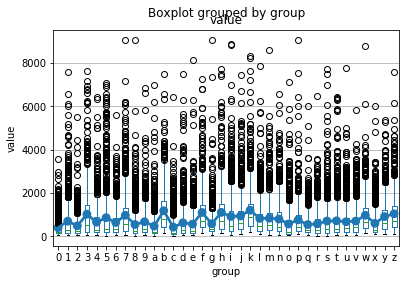

In [6]:
labels = list(similarity_metric.keys())
data = list(similarity_metric.values())

df_labels = [[label for i in range(len(data[i]))] for i, label in enumerate(labels)]
df_labels = sum(df_labels, [])    
df_data = sum(data, [])

df = pd.DataFrame({'value':df_data, 'group':df_labels})
ax = df.boxplot(column='value', by='group', showfliers=True, 
                positions=range(df.group.unique().shape[0]))
sns.pointplot(x='group', y='value', data=df.groupby('group', as_index=False).mean(), ax=ax)


Sorted by median value

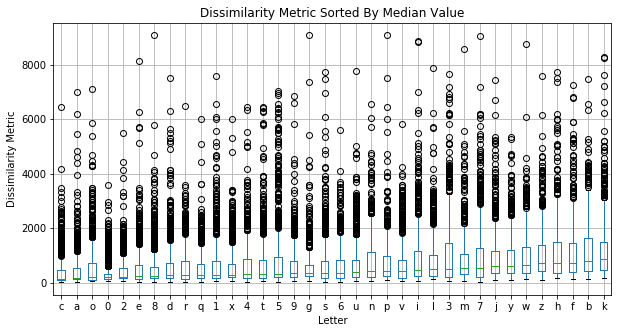

In [7]:
grouped = df.groupby(["group"])

df2 = pd.DataFrame({col:vals['value'] for col,vals in grouped})
meds = df2.median()
meds = meds.sort_values()
df2 = df2[meds.index]
ax = df2.boxplot(figsize=(10,5))
plt.xlabel("Letter")
plt.ylabel("Dissimilarity Metric")
plt.title("Dissimilarity Metric Sorted By Median Value")
plt.show()
fig = ax.get_figure()
fig.savefig("Dissimilarity_by_median.svg")

Sorted by 75th percentile

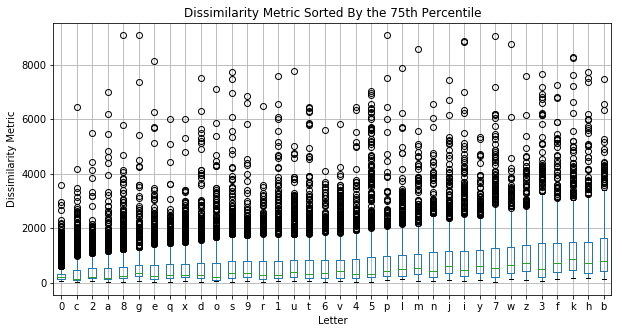

In [8]:
quantile_letters = df2.quantile(0.75)
quantile_letters = quantile_letters.sort_values()
df2 = df2[quantile_letters.index]
ax = df2.boxplot(figsize=(10,5))
plt.xlabel("Letter")
plt.ylabel("Dissimilarity Metric")
plt.title("Dissimilarity Metric Sorted By the 75th Percentile")
plt.show()
fig = ax.get_figure()
fig.savefig("Dissimilarity_by_percentile.svg")

### Normalize The Obtained Values

By the maximum median value obtained for the different letters

In [9]:
median_similarities = dict()
for letter in similarity_metric.keys():
    med_val = np.median(similarity_metric[letter])
    median_similarities[letter] = med_val
    
sorted_by_value = sorted(median_similarities.items(), key=lambda kv: kv[1]) 
max_val = max(list(median_similarities.values()))
normalized_median_similarities = dict()

for letter in similarity_metric.keys():
    med_val = np.median(similarity_metric[letter])
    normalized_median_similarities[letter] = med_val/max_val
    
sorted_normalized_by_value_med = sorted(normalized_median_similarities.items(), key=lambda kv: kv[1])

By the maximum 75h percentile obtained for the different letters

In [10]:
quantile_similarities = dict()
for letter in similarity_metric.keys():
    quantile_similarities[letter] = np.percentile(similarity_metric[letter], 75)
 
sorted_by_value = sorted(quantile_similarities.items(), key=lambda kv: kv[1])

max_val = max(list(quantile_similarities.values()))

normalized_quantile_similarities = dict()

for letter in similarity_metric.keys():
    normalized_quantile_similarities[letter] = np.percentile(similarity_metric[letter], 75)/max_val

sorted_normalized_by_value_quant = sorted(normalized_quantile_similarities.items(), key=lambda kv: kv[1])

Plot one with respect to the other

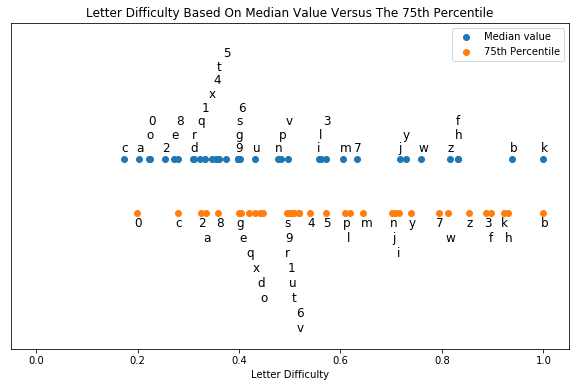

In [11]:
normalized_med_vals = [x[1] for x in sorted_normalized_by_value_med]
normalized_med_labels = [x[0] for x in sorted_normalized_by_value_med]
normalized_quant_vals = [x[1] for x in sorted_normalized_by_value_quant]
normalized_quant_labels = [x[0] for x in sorted_normalized_by_value_quant]

fig, ax = plt.subplots(figsize = (10,6))
plt.ylim((-6, 6))
plt.xlim((-0.05, 1.05))
med = ax.scatter(normalized_med_vals, [1 for i in range(len(normalized_med_vals))])
quant = ax.scatter(normalized_quant_vals, [-1 for i in range(len(normalized_quant_vals))])

y_offset = 0.25
prev_xpos = -100
prev_ypos = -100
for i, val in enumerate(normalized_med_vals): 
    x = normalized_med_vals[i]-0.005
    y = 1+y_offset
    if (x-prev_xpos<0.02):
        y = prev_ypos+0.5
    ax.annotate(normalized_med_labels[i], (x,y), size=12)
    prev_xpos = x
    prev_ypos = y

prev_xpos = -100
prev_ypos = -100
y_offset = 0.5

for i, val in enumerate(normalized_quant_vals):
    x = normalized_quant_vals[i]-0.005
    y = -1-y_offset
    if (x-prev_xpos<0.02):
        y = prev_ypos-0.55
    ax.annotate(normalized_quant_labels[i], (x,y), size=12)
    prev_xpos = x
    prev_ypos = y

plt.xlabel("Letter Difficulty")
plt.legend((med, quant), ("Median value", "75th Percentile"), scatterpoints = 1)
plt.title("Letter Difficulty Based On Median Value Versus The 75th Percentile")

ax.axes.get_yaxis().set_visible(False)
fig.savefig("Dissimilarity_median_versus_percentile.svg")

### Saving the obtained difficulty Metric
Here the one with the 75th percentile

In [12]:
import pickle
letter_difficulty_metric = dict(zip(normalized_quant_labels, normalized_quant_vals))
pkl_file = open("letter_difficulty_metric.pkl", 'wb')
data = pickle.dump(letter_difficulty_metric, pkl_file)
pkl_file.close()